## Memo

* Install kaggle-cli, set competition `kg -c 'compname'` and download dataset `kg download`
* move all `cat*` to `cats/`, same for dogs
* take 1000 random pictures and move them to valid/cats/ with `shuf -n 1000 -e train/cat* | xargs -i mv {} valid/cats/`, same for dogs
Furthermore use
* `ls /train/cats/ | wc -l` to count files in `/train/cats/`
* `ls /train/cats/ | grep -v 'cat'` to find all files that DON'T have cat in it. `-v`-flag inverts search.
* use: `mv /train/cat* /valid/cats` and `cp` to do the rest
* copy utils etc: `cp -t ~/fastai/ vgg16.py vgg16bn.py utils.py resnet50.py`

* sending files over scp:
`scp -i ~/.ssh/aws-key-fast-ai.pem ./zip.zip ubuntu@ec2

* filters bekijken en goeie zwaarder maken

MODEL IDEAS:
* model is underfitting -> reduce dropout
* implement the Ng approach of seeing where in the pipeline you lose the most acc
* retrain also layer -1 and -2, etc. [not really necessary, it's just binary classification]
* can the fact that all pictures are from one camera help?
* model doesn't recognize far away pictures -> data augmentation zoom out
* model doesn't recognize only leaves as invasive -> ??
* ensembling


## Action plan

Main chapters can be seperately run.
1. Folder ordering
    1. Create train subdirectories and order images in labeled directories
    2. Create valid and sample directories
2. Initiate model
    1. Initiate vgg
    2. Initiate reduced dropout
3. Training
    4. Finetune and train model
    5. Inspect predictions
    6. Test and submit

# 1. Folder ordering

## 1. Create train subdirectories and order images in labeled directories

In [ ]:
# Move train folder to backup and rename to train_unordered
%mkdir $DATA_HOME_DIR/backup
%mv $DATA_HOME_DIR/train $DATA_HOME_DIR/backup
%mv $DATA_HOME_DIR/train $DATA_HOME_DIR/train_unordered

In [33]:
# Change test folder to test/unknown
%mv $DATA_HOME_DIR/test $DATA_HOME_DIR/unknown
%mkdir $DATA_HOME_DIR/test
%mv $DATA_HOME_DIR/unknown $DATA_HOME_DIR/test

In [12]:
# Remove all folders created by this script (not test/ and backup/)
%rm -r $DATA_HOME_DIR/results/
%rm -r $DATA_HOME_DIR/valid/
%rm -r $DATA_HOME_DIR/sample/
%rm -r $DATA_HOME_DIR/train/
%rm -r $DATA_HOME_DIR/models/

rm: cannot remove '/home/ubuntu/fastai/data/invasivespecies/results/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasivespecies/valid/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasivespecies/sample/': No such file or directory
rm: cannot remove '/home/ubuntu/fastai/data/invasivespecies/models/': No such file or directory


In [16]:
# Create directories
%mkdir -p $DATA_HOME_DIR/train/invasive/
%mkdir -p $DATA_HOME_DIR/train/non_invasive/
%mkdir -p $DATA_HOME_DIR/results/
%mkdir -p $DATA_HOME_DIR/models/

In [17]:
def list_pictures_by_label(csvfile):
    plantfile = []
    both = []
    labels = []
    with open(DATA_HOME_DIR+'/'+csvfile+'.csv', 'rb') as f:
        train_labels = csv.reader(f, delimiter=' ')
        temp = next(train_labels)
        for row in train_labels:
            both.append(row)
            plantfile.append(int(row[0][:-2]))
            labels.append(int(row[0][-1:]))
    invasive = [str(plantfile[i])+'.jpg' for i,x in enumerate(labels) if x==1]
    non_invasive = [str(plantfile[i])+'.jpg' for i,x in enumerate(labels) if x==0]
    return invasive, non_invasive

def copy_files_from_train_to_trainlabel(invasive, non_invasive):
    for i in range(len(invasive)):
        shutil.move(DATA_HOME_DIR+'/backup/train_unordered/'+invasive[i], DATA_HOME_DIR+'/train/invasive/')
    for j in range(len(non_invasive)):
        shutil.move(DATA_HOME_DIR+'/backup/train_unordered/'+non_invasive[j], DATA_HOME_DIR+'/train/non_invasive/')

In [19]:
copy_files_from_train_to_trainlabel(*list_pictures_by_label('train_labels'))

## 2. Create valid and sample directories

In [20]:
# Create directories
%mkdir -p $DATA_HOME_DIR/valid/invasive
%mkdir -p $DATA_HOME_DIR/valid/non_invasive
%mkdir -p $DATA_HOME_DIR/results

In [24]:
def move_from_train_to_valid():
    dirs = os.listdir(DATA_HOME_DIR+'/train')
    print(dirs)
    for iterator in dirs:
        if os.listdir(DATA_HOME_DIR+'/valid/'+iterator+'/') == []:
            g = glob.glob(DATA_HOME_DIR+'/train/'+iterator+'/'+'*.jpg')
            shuf = np.random.permutation(g)
            for i in range(int(math.ceil(0.08*len(g)))):
#                 print(DATA_HOME_DIR+'/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
                shutil.move(shuf[i], DATA_HOME_DIR+'/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
        else:
            print('/valid/'+ str(iterator)+ 'folder not empty')

In [25]:
move_from_train_to_valid()

['non_invasive', 'invasive']


In [31]:
# Remove directories
%rm -r $DATA_HOME_DIR/sample/results/
%rm -r $DATA_HOME_DIR/sample/valid/invasive/
%rm -r $DATA_HOME_DIR/sample/valid/non_invasive/
%rm -r $DATA_HOME_DIR/sample/train/invasive/
%rm -r $DATA_HOME_DIR/sample/train/non_invasive/
%rm -r $DATA_HOME_DIR/sample/test/unknown
%rm -r $DATA_HOME_DIR/sample/models/

In [32]:
# Create directories
%mkdir -p $DATA_HOME_DIR/sample/results/
%mkdir -p $DATA_HOME_DIR/sample/valid/invasive/
%mkdir -p $DATA_HOME_DIR/sample/valid/non_invasive/
%mkdir -p $DATA_HOME_DIR/sample/train/invasive/
%mkdir -p $DATA_HOME_DIR/sample/train/non_invasive/
%mkdir -p $DATA_HOME_DIR/sample/test/unknown
%mkdir -p $DATA_HOME_DIR/sample/models/

In [29]:
def create_samplefolder():
    dirs = os.listdir(DATA_HOME_DIR+'/train')
    if os.listdir(DATA_HOME_DIR+'/sample/train/'+dirs[0]+'/') == []:
        for iterator in dirs:
            g = glob.glob(DATA_HOME_DIR+'/train/'+iterator+'/'+'*.jpg')
            shuf = np.random.permutation(g)
            for i in range(20):
                shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/train/'+iterator+'/'+ os.path.basename(shuf[i]))
            for i in range(10):
                shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/valid/'+iterator+'/'+ os.path.basename(shuf[i]))
    else:
        print('/sample/train/ or /sample/valid/ folder not empty')
    if os.listdir(DATA_HOME_DIR+'/sample/test/unknown/') == []:
        g = glob.glob(DATA_HOME_DIR+'/test/unknown/'+'*.jpg')
        shuf = np.random.permutation(g)
        for i in range(10):
                    shutil.copyfile(shuf[i], DATA_HOME_DIR+'/sample/test/unknown/'+ os.path.basename(shuf[i]))
    else:
        print('/sample/test/unknown/ folder not empty')

In [34]:
create_samplefolder()

779
1332
1531


# 2. Initiate model

## 1. Initiate vgg

In [47]:
# Import modules
import csv
import shutil
import glob
import os, sys
import numpy as np
import math
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from IPython.display import FileLink


# Set directories
HOME_DIR = os.getcwd()
DATA_PATH = 'data/invasivespecies'
DATA_HOME_DIR = os.path.abspath(HOME_DIR+'/'+DATA_PATH)

# path = DATA_HOME_DIR + '/sample/'
path = DATA_HOME_DIR

train_path = path + '/train/'
valid_path = path + '/valid/'
test_path = path + '/test/'
results_path= path + '/results/'
model_path = path + '/models/'

In [2]:
import vgg16stijn; reload(vgg16stijn)
from vgg16stijn import Vgg16Stijn
vgg = Vgg16Stijn()

import utils; reload(utils)
from utils import *

%matplotlib inline

In [3]:
batch_size = 64
run_approach_name = 'loss_binary'

## 2. Initiate vgg + dropout

### Plan

1. make seperate conv and fc part
2. do other stuff

### vgg + dropout

In [90]:
# Import modules
import csv
import shutil
import glob
import os, sys
import numpy as np
import math
import json
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from IPython.display import FileLink
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.np_utils import to_categorical
import bcolz

%matplotlib inline

# Set directories
HOME_DIR = os.getcwd()
DATA_PATH = 'data/invasivespecies'
DATA_HOME_DIR = os.path.abspath(HOME_DIR+'/'+DATA_PATH)

# path = DATA_HOME_DIR + '/sample/'
path = DATA_HOME_DIR

train_path = path + '/train/'
valid_path = path + '/valid/'
test_path = path + '/test/'
results_path= path + '/results/'
model_path = DATA_HOME_DIR + '/models/'

In [91]:
drop1 = 0.25
drop2 = drop1
drop = 0.25
batch_size = 64
run_approach_name = 'adjust_dropout_0_25_'

In [92]:
# import utils; reload(utils)
# from utils import *
import vgg16stijn; reload(vgg16stijn)
from vgg16stijn import Vgg16Stijn
vgg = Vgg16Stijn()

In [93]:
vgg.change_number_outputnodes(2)
vgg.model.load_weights(model_path + 'loss_binary_5lrecht0_0001.h5')
vgg_trained = vgg.model

compiling lr = 0.001


In [94]:
# Seperate models into conv and fc
layers = vgg_trained.layers
last_conv_idx = [idx for idx,layer in enumerate(layers) if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

fc_layers = layers[last_conv_idx+1:]

In [23]:
batches = vgg.batch_iterator(train_path, shuffle=False, batch_size=batch_size)
val_batches = vgg.batch_iterator(valid_path, shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = to_categorical(val_classes)
trn_labels = to_categorical(trn_classes)

Found 2111 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [24]:
%%time
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [25]:
%%time
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [26]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

In [27]:
# save_array(model_path + 'train_convlayer_features.bc', trn_features)
# save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [28]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [29]:
trn_features.shape

(2111, 512, 14, 14)

In [95]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer, drop=drop): return [o/(2*(1-drop)) for o in layer.get_weights()]

In [96]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [97]:
def adjust_fc_layers():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        
        Dense(4096, activation='relu'),
        Dropout(drop1),
        
        Dense(4096, activation='relu'),
        Dropout(drop2),
        
        Dense(2, activation='softmax')
            
        ])
    
    dropout_layer = [idx for idx,layer in enumerate(model.layers) if type(layer) is Dropout]
    pre_dropout_layer = [x - 1 for x in dropout_layer]
    
    for do_layer in pre_dropout_layer:
#         print(model.layers[do_layer], fc_layers[do_layer])
        model.layers[do_layer].set_weights(proc_wgts(fc_layers[do_layer]))
#     print(model.summary())
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
fc_model = adjust_fc_layers()

In [33]:
fc_model.fit(trn_features, trn_labels, nb_epoch=8, batch_size=batch_size, validation_data=(val_features, val_labels))

Train on 2111 samples, validate on 184 samples
Epoch 1/8
2111/2111 [==============================] - 3s - loss: 0.3242 - acc: 0.8494 - val_loss: 0.2342 - val_acc: 0.8913
Epoch 2/8
2111/2111 [==============================] - 3s - loss: 0.1718 - acc: 0.9299 - val_loss: 0.2325 - val_acc: 0.9130
Epoch 3/8
2111/2111 [==============================] - 3s - loss: 0.1258 - acc: 0.9531 - val_loss: 0.2667 - val_acc: 0.8913
Epoch 4/8
2111/2111 [==============================] - 3s - loss: 0.0818 - acc: 0.9668 - val_loss: 0.2772 - val_acc: 0.8913
Epoch 5/8
2111/2111 [==============================] - 3s - loss: 0.0598 - acc: 0.9773 - val_loss: 0.3442 - val_acc: 0.8967
Epoch 6/8
2111/2111 [==============================] - 3s - loss: 0.0300 - acc: 0.9891 - val_loss: 0.3220 - val_acc: 0.8967
Epoch 7/8
2111/2111 [==============================] - 3s - loss: 0.0205 - acc: 0.9938 - val_loss: 0.3547 - val_acc: 0.8967
Epoch 8/8
2111/2111 [==============================] - 3s - loss: 0.0108 - acc: 0.996

In [34]:
fc_model.save_weights(model_path+'no_dropout.h5')

In [35]:
fc_model.load_weights(model_path+'no_dropout.h5')

### vgg + dropout + data augmentation

In [99]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [100]:
batches = vgg.batch_iterator(train_path, gen, batch_size=batch_size)

Found 2111 images belonging to 2 classes.


In [101]:
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

In [102]:
conv_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=50, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/50
2111/2111 [==============================] - 93s - loss: 0.3810 - acc: 0.8186 - val_loss: 0.2972 - val_acc: 0.8696
Epoch 2/50
2111/2111 [==============================] - 82s - loss: 0.2531 - acc: 0.8920 - val_loss: 0.3237 - val_acc: 0.8696
Epoch 3/50
2111/2111 [==============================] - 82s - loss: 0.2403 - acc: 0.9029 - val_loss: 0.2627 - val_acc: 0.8859
Epoch 4/50
2111/2111 [==============================] - 76s - loss: 0.2059 - acc: 0.9143 - val_loss: 0.2599 - val_acc: 0.8913
Epoch 5/50
2111/2111 [==============================] - 83s - loss: 0.1991 - acc: 0.9162 - val_loss: 0.2591 - val_acc: 0.9022
Epoch 6/50
1728/2111 [=======================>......] - ETA: 13s - loss: 0.1884 - acc: 0.9196

In [ ]:
conv_model.save_weights(model_path + 'd0_25_e_50_lr_0_00001.h5')

In [41]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=8, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
2111/2111 [==============================] - 86s - loss: 0.1674 - acc: 0.9408 - val_loss: 0.2908 - val_acc: 0.9239
Epoch 2/8
2111/2111 [==============================] - 89s - loss: 0.1427 - acc: 0.9403 - val_loss: 0.3024 - val_acc: 0.9293
Epoch 3/8
2111/2111 [==============================] - 88s - loss: 0.1463 - acc: 0.9469 - val_loss: 0.2902 - val_acc: 0.9185
Epoch 4/8
2111/2111 [==============================] - 78s - loss: 0.1294 - acc: 0.9484 - val_loss: 0.3452 - val_acc: 0.9239
Epoch 5/8
2111/2111 [==============================] - 82s - loss: 0.1308 - acc: 0.9541 - val_loss: 0.3370 - val_acc: 0.9293
Epoch 6/8
2111/2111 [==============================] - 85s - loss: 0.1434 - acc: 0.9446 - val_loss: 0.3496 - val_acc: 0.9348
Epoch 7/8
2111/2111 [==============================] - 83s - loss: 0.1251 - acc: 0.9503 - val_loss: 0.3584 - val_acc: 0.9239
Epoch 8/8
2111/2111 [==============================] - 90s - loss: 0.1211 - acc: 0.9536 - val_loss: 0.3413 - val_acc: 0.9293


In [42]:
conv_model.save_weights(model_path + 'aug1.h5')

In [43]:
conv_model.load_weights(model_path + 'aug1.h5')

tits


In [41]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=34, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/8
2111/2111 [==============================] - 86s - loss: 0.1674 - acc: 0.9408 - val_loss: 0.2908 - val_acc: 0.9239
Epoch 2/8
2111/2111 [==============================] - 89s - loss: 0.1427 - acc: 0.9403 - val_loss: 0.3024 - val_acc: 0.9293
Epoch 3/8
2111/2111 [==============================] - 88s - loss: 0.1463 - acc: 0.9469 - val_loss: 0.2902 - val_acc: 0.9185
Epoch 4/8
2111/2111 [==============================] - 78s - loss: 0.1294 - acc: 0.9484 - val_loss: 0.3452 - val_acc: 0.9239
Epoch 5/8
2111/2111 [==============================] - 82s - loss: 0.1308 - acc: 0.9541 - val_loss: 0.3370 - val_acc: 0.9293
Epoch 6/8
2111/2111 [==============================] - 85s - loss: 0.1434 - acc: 0.9446 - val_loss: 0.3496 - val_acc: 0.9348
Epoch 7/8
2111/2111 [==============================] - 83s - loss: 0.1251 - acc: 0.9503 - val_loss: 0.3584 - val_acc: 0.9239
Epoch 8/8
2111/2111 [==============================] - 90s - loss: 0.1211 - acc: 0.9536 - val_loss: 0.3413 - val_acc: 0.9293


In [42]:
conv_model.save_weights(model_path + 'aug50epoch.h5')

In [43]:
conv_model.load_weights(model_path + 'aug50epoch.h5')

In [78]:
vgg.model = conv_model

In [80]:
test_batches, test_probs = vgg.test(test_path, batch_size=batch_size)

Found 1531 images belonging to 1 classes.


In [81]:
filenames = test_batches.filenames

In [82]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', test_probs)
save_array(results_path + 'filenames.dat', filenames)

In [83]:
file_numbers = [int(filenames[i][8:-4]) for i in range(len(filenames))]

In [84]:
def write_csv(name, predictions, details=''):
    with open(path+'/results/'+'test_'+ str(details) +'.csv', 'wb') as f:
        fieldnames = ['name', 'invasive']
        wr = csv.writer(f, delimiter=',')
        wr.writerow(fieldnames)
        for i in range(len(predictions)):
            wr.writerow([name[i],predictions[i]])
    return FileLink(DATA_PATH+'/results/'+'test_'+ str(details) +'.csv')

In [85]:
write_csv(file_numbers, test_probs[:,0], run_approach_name)

/home/ubuntu/fastai/data/invasivespecies/results/test_adjust_dropout_dr1_0.25_dr2_0.25_.csv

In [86]:
%cd ~/fastai

/home/ubuntu/fastai


In [87]:
%ls

1_image_recognition_catsanddogs.ipynb      test.csv
1_image_recognition_invasivespecies.ipynb  utils.py*
2_CNNs.ipynb                               utils.pyc
Lesson_3.ipynb                             utils_anders.py
ToDo.ipynb                                 vgg16.py*
batches.npy                                vgg16.pyc
data/                                      vgg16bn.py*
edit_util_files.ipynb                      vgg16bn.pyc
lesson1.ipynb                              vgg16stijn.py*
resnet50.py*                               vgg16stijn.pyc


In [88]:
print('data/invasiveplants/results/'+ run_approach_name +'.csv')

data/invasiveplants/results/adjust_dropout_dr1_0.25_dr2_0.25_.csv


In [57]:
# from IPython.display import FileLink
# FileLink('data/invasiveplants/results/'+ run_approach_name +'.csv')

/home/ubuntu/fastai/data/invasiveplants/results/test_fourth_43_epochs.csv

### vgg + dropout + data augmentation + batchnorm

#### create fc part

In [1]:
# Import modules
import csv
import shutil
import glob
import os, sys
import numpy as np
import math
import json
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from IPython.display import FileLink
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.normalization import BatchNormalization
from keras.optimizers import Adam, SGD, RMSprop
from keras.utils.np_utils import to_categorical
import bcolz

%matplotlib inline

# Set directories
HOME_DIR = os.getcwd()
DATA_PATH = 'data/invasivespecies'
DATA_HOME_DIR = os.path.abspath(HOME_DIR+'/'+DATA_PATH)

# path = DATA_HOME_DIR + '/sample/'
path = DATA_HOME_DIR

train_path = path + '/train/'
valid_path = path + '/valid/'
test_path = path + '/test/'
results_path= path + '/results/'
model_path = DATA_HOME_DIR + '/models/'

Using Theano backend.
Using gpu device 0: Tesla K80 (CNMeM is disabled, cuDNN 5103)
/home/ubuntu/anaconda2/lib/python2.7/site-packages/theano/sandbox/cuda/__init__.py:600: UserWarning: Your cuDNN version is more recent than the one Theano officially supports. If you see any problems, try updating Theano or downgrading cuDNN to version 5.
  warnings.warn(warn)


In [75]:
drop1 = 0.25
drop2 = drop1
drop = 0.6
batch_size = 64
run_approach_name = 'adjust_dropout_0_6_batchnorm_'

In [50]:
# import utils; reload(utils)
# from utils import *
import vgg16stijn; reload(vgg16stijn)
from vgg16stijn import Vgg16Stijn
vgg = Vgg16Stijn()

from vgg16bn import Vgg16BN

In [51]:
# vgg.change_number_outputnodes(2)
# vgg.model.load_weights(model_path + 'loss_binary_5lrecht0_0001.h5')
# vgg_trained = vgg.model

In [52]:
# Seperate models into conv and fc
vgg_model = vgg.model
layers = vgg_model.layers
last_conv_idx = [idx for idx,layer in enumerate(layers) if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

fc_layers = layers[last_conv_idx+1:]

In [53]:
def get_bn_layers(drop=drop):
    return [
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(drop),
        Dense(4096, activation='relu'),
        BatchNormalization(),
        Dropout(drop),
        Dense(1000, activation='softmax')
        ]

In [54]:
def split_at(model, layer_type):
    layers = model.layers
    layer_idx = [index for index,layer in enumerate(layers)
                 if type(layer) is layer_type][-1]
    return layers[:layer_idx+1], layers[layer_idx+1:]

In [55]:
def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())

In [56]:
def load_fc_weights_from_vgg16bn(model):
    "Load weights for model from the dense layers of the Vgg16BN model."
    # See imagenet_batchnorm.ipynb for info on how the weights for
    # Vgg16BN can be generated from the standard Vgg16 weights.
    from vgg16bn import Vgg16BN
    vgg16_bn = Vgg16BN()
    _, fc_layers = split_at(vgg16_bn.model, Convolution2D)
    copy_weights(fc_layers, model.layers)

In [57]:
bn_model = Sequential(get_bn_layers())

In [58]:
load_fc_weights_from_vgg16bn(bn_model)

In [59]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer, drop=drop): return [o/(2*(1-drop)) for o in layer.get_weights()]

In [60]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [61]:
for l in bn_model.layers: 
    if type(l)==Dense: l.set_weights(proc_wgts(l, drop))

In [62]:
bn_model.pop()
for layer in bn_model.layers: layer.trainable=False

In [63]:
bn_model.add(Dense(2,activation='softmax'))

In [64]:
bn_model.compile(Adam(), 'binary_crossentropy', metrics=['accuracy'])

#### train fc part

In [65]:
batches = vgg.batch_iterator(train_path, shuffle=False, batch_size=batch_size)
val_batches = vgg.batch_iterator(valid_path, shuffle=False, batch_size=batch_size)

val_classes = val_batches.classes
trn_classes = batches.classes
val_labels = to_categorical(val_classes)
trn_labels = to_categorical(trn_classes)

Found 2111 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [19]:
# %%time
val_features = conv_model.predict_generator(val_batches, val_batches.nb_sample)

In [20]:
# %%time
trn_features = conv_model.predict_generator(batches, batches.nb_sample)

In [66]:
def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]

In [22]:
save_array(model_path + 'train_convlayer_features.bc', trn_features)
save_array(model_path + 'valid_convlayer_features.bc', val_features)

In [67]:
trn_features = load_array(model_path+'train_convlayer_features.bc')
val_features = load_array(model_path+'valid_convlayer_features.bc')

In [68]:
trn_features.shape

(2111, 512, 14, 14)

In [73]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 2111 samples, validate on 184 samples
Epoch 1/8
2111/2111 [==============================] - 1s - loss: 0.6346 - acc: 0.8877 - val_loss: 0.8333 - val_acc: 0.8587
Epoch 2/8
2111/2111 [==============================] - 1s - loss: 0.6746 - acc: 0.8858 - val_loss: 0.8714 - val_acc: 0.8478
Epoch 3/8
2111/2111 [==============================] - 1s - loss: 0.6972 - acc: 0.8844 - val_loss: 0.9666 - val_acc: 0.8587
Epoch 4/8
2111/2111 [==============================] - 1s - loss: 0.6861 - acc: 0.8839 - val_loss: 0.8438 - val_acc: 0.8587
Epoch 5/8
2111/2111 [==============================] - 1s - loss: 0.6559 - acc: 0.8934 - val_loss: 0.8215 - val_acc: 0.8587
Epoch 6/8
2111/2111 [==============================] - 1s - loss: 0.6336 - acc: 0.8963 - val_loss: 0.8394 - val_acc: 0.8696
Epoch 7/8
2111/2111 [==============================] - 1s - loss: 0.6096 - acc: 0.8972 - val_loss: 1.0150 - val_acc: 0.8587
Epoch 8/8
2111/2111 [==============================] - 1s - loss: 0.7296 - acc: 0.887

In [74]:
bn_model.fit(trn_features, trn_labels, nb_epoch=8, validation_data=(val_features, val_labels))

Train on 2111 samples, validate on 184 samples
Epoch 1/8
2111/2111 [==============================] - 1s - loss: 0.6771 - acc: 0.8948 - val_loss: 0.7273 - val_acc: 0.8804
Epoch 2/8
2111/2111 [==============================] - 1s - loss: 0.5512 - acc: 0.9053 - val_loss: 0.7898 - val_acc: 0.8804
Epoch 3/8
2111/2111 [==============================] - 1s - loss: 0.6350 - acc: 0.8958 - val_loss: 0.9001 - val_acc: 0.8587
Epoch 4/8
2111/2111 [==============================] - 1s - loss: 0.6722 - acc: 0.8906 - val_loss: 0.7810 - val_acc: 0.8750
Epoch 5/8
2111/2111 [==============================] - 1s - loss: 0.7113 - acc: 0.8910 - val_loss: 0.9040 - val_acc: 0.8641
Epoch 6/8
2111/2111 [==============================] - 1s - loss: 0.6425 - acc: 0.8896 - val_loss: 0.8548 - val_acc: 0.8696
Epoch 7/8
2111/2111 [==============================] - 1s - loss: 0.6458 - acc: 0.8972 - val_loss: 0.8261 - val_acc: 0.8587
Epoch 8/8
2111/2111 [==============================] - 1s - loss: 0.7000 - acc: 0.885

In [77]:
bn_model.save_weights(model_path+'bn0_6d48e.h5')

In [ ]:
bn_model.load_weights(model_path+'bn0_6d48e.h5')

#### add trained fc part to conv part

In [78]:
bn_layers = get_bn_layers(drop)
bn_layers.pop()
bn_layers.append(Dense(2,activation='softmax'))

In [79]:
final_model = Sequential(conv_layers)
for layer in final_model.layers: layer.trainable = False
for layer in bn_layers: final_model.add(layer)

In [71]:
# print(bn_model.layers)
# print(bn_layers)
# bn_model.summary()


[<keras.layers.pooling.MaxPooling2D object at 0x7f988415bc50>, <keras.layers.core.Flatten object at 0x7f988415bcd0>, <keras.layers.core.Dense object at 0x7f988415bc10>, <keras.layers.normalization.BatchNormalization object at 0x7f988415bd50>, <keras.layers.core.Dropout object at 0x7f988415bd90>, <keras.layers.core.Dense object at 0x7f988415bdd0>, <keras.layers.normalization.BatchNormalization object at 0x7f988415be50>, <keras.layers.core.Dropout object at 0x7f988415bed0>, <keras.layers.core.Dense object at 0x7f9883dada10>]
[<keras.layers.pooling.MaxPooling2D object at 0x7f98835b6610>, <keras.layers.core.Flatten object at 0x7f98835b6690>, <keras.layers.core.Dense object at 0x7f98835b65d0>, <keras.layers.normalization.BatchNormalization object at 0x7f98835b6710>, <keras.layers.core.Dropout object at 0x7f98835b6750>, <keras.layers.core.Dense object at 0x7f98835b6790>, <keras.layers.normalization.BatchNormalization object at 0x7f98835b6810>, <keras.layers.core.Dropout object at 0x7f98835b6

In [80]:
for l1,l2 in zip(bn_model.layers, bn_layers):
    l2.set_weights(l1.get_weights())

In [81]:
final_model.compile(optimizer=Adam(), 
                    loss='binary_crossentropy', metrics=['accuracy'])

In [82]:
gen = image.ImageDataGenerator(rotation_range=20, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [83]:
batches = vgg.batch_iterator(train_path, gen, batch_size=batch_size)

Found 2111 images belonging to 2 classes.


In [84]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
2111/2111 [==============================] - 91s - loss: 3.8511 - acc: 0.7380 - val_loss: 2.5266 - val_acc: 0.8424


In [85]:
final_model.optimizer.lr=0.0001

In [86]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
2111/2111 [==============================] - 95s - loss: 2.9594 - acc: 0.7977 - val_loss: 4.3765 - val_acc: 0.7174


In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/1
1088/2111 [==============>...............] - ETA: 40s - loss: 2.6420 - acc: 0.8189

In [ ]:
final_model.optimizer.lr=0.00001

In [ ]:
final_model.save_weights(model_path + 'final1.h5')

In [ ]:
final_model.load_weights(model_path + 'final1.h5')

In [ ]:
final_model.optimizer.lr=0.001

In [ ]:
final_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=1, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

#### rest

In [92]:
# import utils; reload(utils)
# from utils import *
import vgg16stijn; reload(vgg16stijn)
from vgg16stijn import Vgg16Stijn
vgg = Vgg16Stijn()

In [93]:
vgg.change_number_outputnodes(2)
vgg.model.load_weights(model_path + 'loss_binary_5lrecht0_0001.h5')
vgg_trained = vgg.model

compiling lr = 0.001


In [94]:
# Seperate models into conv and fc
layers = vgg_trained.layers
last_conv_idx = [idx for idx,layer in enumerate(layers) if type(layer) is Convolution2D][-1]

conv_layers = layers[:last_conv_idx+1]
conv_model = Sequential(conv_layers)

fc_layers = layers[last_conv_idx+1:]

In [95]:
# Copy the weights from the pre-trained model.
# NB: Since we're removing dropout, we want to half the weights
def proc_wgts(layer, drop=drop): return [o/(2*(1-drop)) for o in layer.get_weights()]

In [96]:
# Such a finely tuned model needs to be updated very slowly!
opt = RMSprop(lr=0.00001, rho=0.7)

In [97]:
def adjust_fc_layers():
    model = Sequential([
        MaxPooling2D(input_shape=conv_layers[-1].output_shape[1:]),
        Flatten(),
        
        Dense(4096, activation='relu'),
        Dropout(drop1),
        
        Dense(4096, activation='relu'),
        Dropout(drop2),
        
        Dense(2, activation='softmax')
            
        ])
    
    dropout_layer = [idx for idx,layer in enumerate(model.layers) if type(layer) is Dropout]
    pre_dropout_layer = [x - 1 for x in dropout_layer]
    
    for do_layer in pre_dropout_layer:
#         print(model.layers[do_layer], fc_layers[do_layer])
        model.layers[do_layer].set_weights(proc_wgts(fc_layers[do_layer]))
#     print(model.summary())
    model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])
    return model

In [98]:
fc_model = adjust_fc_layers()

In [99]:
gen = image.ImageDataGenerator(rotation_range=15, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)

In [100]:
batches = vgg.batch_iterator(train_path, gen, batch_size=batch_size)

Found 2111 images belonging to 2 classes.


In [101]:
for layer in conv_model.layers: layer.trainable = False
# Look how easy it is to connect two models together!
conv_model.add(fc_model)

In [102]:
conv_model.compile(optimizer=opt, loss='binary_crossentropy', metrics=['accuracy'])

In [ ]:
conv_model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=50, 
                        validation_data=val_batches, nb_val_samples=val_batches.nb_sample)

Epoch 1/50
2111/2111 [==============================] - 93s - loss: 0.3810 - acc: 0.8186 - val_loss: 0.2972 - val_acc: 0.8696
Epoch 2/50
2111/2111 [==============================] - 82s - loss: 0.2531 - acc: 0.8920 - val_loss: 0.3237 - val_acc: 0.8696
Epoch 3/50
2111/2111 [==============================] - 82s - loss: 0.2403 - acc: 0.9029 - val_loss: 0.2627 - val_acc: 0.8859
Epoch 4/50
2111/2111 [==============================] - 76s - loss: 0.2059 - acc: 0.9143 - val_loss: 0.2599 - val_acc: 0.8913
Epoch 5/50
2111/2111 [==============================] - 83s - loss: 0.1991 - acc: 0.9162 - val_loss: 0.2591 - val_acc: 0.9022
Epoch 6/50
1728/2111 [=======================>......] - ETA: 13s - loss: 0.1884 - acc: 0.9196

In [ ]:
conv_model.save_weights(model_path + 'd0_25_e_50_lr_0_00001.h5')

In [ ]:
conv_model.load_weights(model_path + 'd0_25_e_50_lr_0_00001.h5')

In [78]:
vgg.model = conv_model

In [80]:
test_batches, test_probs = vgg.test(test_path, batch_size=batch_size)

Found 1531 images belonging to 1 classes.


In [81]:
filenames = test_batches.filenames

In [82]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', test_probs)
save_array(results_path + 'filenames.dat', filenames)

In [83]:
file_numbers = [int(filenames[i][8:-4]) for i in range(len(filenames))]

In [84]:
def write_csv(name, predictions, details=''):
    with open(path+'/results/'+'test_'+ str(details) +'.csv', 'wb') as f:
        fieldnames = ['name', 'invasive']
        wr = csv.writer(f, delimiter=',')
        wr.writerow(fieldnames)
        for i in range(len(predictions)):
            wr.writerow([name[i],predictions[i]])
    return FileLink(DATA_PATH+'/results/'+'test_'+ str(details) +'.csv')

In [85]:
write_csv(file_numbers, test_probs[:,0], run_approach_name)

/home/ubuntu/fastai/data/invasivespecies/results/test_adjust_dropout_dr1_0.25_dr2_0.25_.csv

# 3. Training

## 1. Finetune and train model

In [5]:
gen = image.ImageDataGenerator(rotation_range=10, width_shift_range=0.1, 
                               height_shift_range=0.1, zoom_range=0.1, horizontal_flip=True)
batches = vgg.batch_iterator(train_path, gen, batch_size=batch_size)
val_batches = vgg.batch_iterator(valid_path, batch_size=batch_size*2)

Found 2111 images belonging to 2 classes.
Found 184 images belonging to 2 classes.


In [6]:
vgg.correct_class_id(batches)
print(vgg.classes)

['invasive', 'non_invasive']


In [7]:
%%time
nb_epoch = 1
vgg.model.optimizer.lr = 0.001
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/1
2111/2111 [==============================] - 98s - loss: 0.6217 - acc: 0.7717 - val_loss: 0.4045 - val_acc: 0.8641
CPU times: user 2min 30s, sys: 15.2 s, total: 2min 45s
Wall time: 2min 1s


In [8]:
vgg.model.save_weights(model_path+run_approach_name+'_lr0_001.h5')

In [9]:
vgg.model.load_weights(model_path+run_approach_name+'_lr0_001.h5')

In [10]:
nb_epoch = 1
vgg.model.optimizer.lr = 0.0005
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/1
2111/2111 [==============================] - 89s - loss: 0.4595 - acc: 0.8394 - val_loss: 0.2949 - val_acc: 0.9076


In [11]:
vgg.model.save_weights(model_path+run_approach_name+'_lr0_0005.h5')

In [12]:
vgg.model.load_weights(model_path+run_approach_name+'_lr0_0005.h5')

In [13]:
nb_epoch = 5
vgg.model.optimizer.lr = 0.001
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/5
2111/2111 [==============================] - 87s - loss: 0.4977 - acc: 0.8176 - val_loss: 0.2436 - val_acc: 0.8913
Epoch 2/5
2111/2111 [==============================] - 88s - loss: 0.4385 - acc: 0.8408 - val_loss: 0.2912 - val_acc: 0.8804
Epoch 3/5
2111/2111 [==============================] - 81s - loss: 0.3695 - acc: 0.8427 - val_loss: 0.3552 - val_acc: 0.8370
Epoch 4/5
2111/2111 [==============================] - 75s - loss: 0.4246 - acc: 0.8342 - val_loss: 0.2902 - val_acc: 0.8913
Epoch 5/5
2111/2111 [==============================] - 75s - loss: 0.3898 - acc: 0.8494 - val_loss: 0.2812 - val_acc: 0.8750


In [14]:
vgg.model.save_weights(model_path+run_approach_name+'_5lr0_001.h5')

In [15]:
vgg.model.load_weights(model_path+run_approach_name+'_5lr0_001.h5')

In [16]:
nb_epoch = 5
vgg.model.optimizer.lr = 0.0005
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/5
2111/2111 [==============================] - 87s - loss: 0.3522 - acc: 0.8555 - val_loss: 0.3126 - val_acc: 0.8641
Epoch 2/5
2111/2111 [==============================] - 76s - loss: 0.3791 - acc: 0.8541 - val_loss: 0.2935 - val_acc: 0.8696
Epoch 3/5
2111/2111 [==============================] - 77s - loss: 0.3248 - acc: 0.8603 - val_loss: 0.2711 - val_acc: 0.8913
Epoch 4/5
2111/2111 [==============================] - 90s - loss: 0.3700 - acc: 0.8550 - val_loss: 0.2861 - val_acc: 0.8859
Epoch 5/5
2111/2111 [==============================] - 85s - loss: 0.3355 - acc: 0.8631 - val_loss: 0.2710 - val_acc: 0.8859


In [17]:
vgg.model.save_weights(model_path+run_approach_name+'_5lr0_0005.h5')

In [18]:
vgg.model.load_weights(model_path+run_approach_name+'_5lr0_0005.h5')

In [19]:
nb_epoch = 10
vgg.model.optimizer.lr = 0.0005
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/10
2111/2111 [==============================] - 91s - loss: 0.3232 - acc: 0.8659 - val_loss: 0.2933 - val_acc: 0.8750
Epoch 2/10
2111/2111 [==============================] - 82s - loss: 0.3212 - acc: 0.8688 - val_loss: 0.2394 - val_acc: 0.8967
Epoch 3/10
2111/2111 [==============================] - 86s - loss: 0.3366 - acc: 0.8631 - val_loss: 0.2782 - val_acc: 0.8967
Epoch 4/10
2111/2111 [==============================] - 75s - loss: 0.3713 - acc: 0.8503 - val_loss: 0.3702 - val_acc: 0.8696
Epoch 5/10
2111/2111 [==============================] - 87s - loss: 0.3317 - acc: 0.8640 - val_loss: 0.3157 - val_acc: 0.8804
Epoch 6/10
2111/2111 [==============================] - 80s - loss: 0.3108 - acc: 0.8664 - val_loss: 0.2944 - val_acc: 0.8533
Epoch 7/10
2111/2111 [==============================] - 74s - loss: 0.3328 - acc: 0.8664 - val_loss: 0.3206 - val_acc: 0.8696
Epoch 8/10
2111/2111 [==============================] - 79s - loss: 0.3969 - acc: 0.8465 - val_loss: 0.2979 - val_acc:

In [20]:
vgg.model.save_weights(model_path+run_approach_name+'_15lr0_0005.h5')

In [21]:
vgg.model.load_weights(model_path+run_approach_name+'_15lr0_0005.h5')

In [50]:
nb_epoch = 20
vgg.model.optimizer.lr = 0.0005
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/20
2111/2111 [==============================] - 85s - loss: 0.3539 - acc: 0.8617 - val_loss: 0.2934 - val_acc: 0.8750
Epoch 2/20
2111/2111 [==============================] - 75s - loss: 0.3425 - acc: 0.8669 - val_loss: 0.2842 - val_acc: 0.8750
Epoch 3/20
2111/2111 [==============================] - 74s - loss: 0.3366 - acc: 0.8678 - val_loss: 0.3264 - val_acc: 0.8533
Epoch 4/20
2111/2111 [==============================] - 80s - loss: 0.3460 - acc: 0.8546 - val_loss: 0.3445 - val_acc: 0.8478
Epoch 5/20
2111/2111 [==============================] - 83s - loss: 0.3534 - acc: 0.8588 - val_loss: 0.3566 - val_acc: 0.8804
Epoch 6/20
2111/2111 [==============================] - 82s - loss: 0.3600 - acc: 0.8536 - val_loss: 0.3108 - val_acc: 0.8859
Epoch 7/20
2111/2111 [==============================] - 77s - loss: 0.3294 - acc: 0.8603 - val_loss: 0.4357 - val_acc: 0.8641
Epoch 8/20
2111/2111 [==============================] - 83s - loss: 0.3158 - acc: 0.8688 - val_loss: 0.2712 - val_acc:

In [51]:
vgg.model.save_weights(model_path+run_approach_name+'_35lr0_0005.h5')

In [52]:
vgg.model.load_weights(model_path+run_approach_name+'_35lr0_0005.h5')

In [59]:
nb_epoch = 5
vgg.model.optimizer.lr = 0.0001
vgg.fit(batches, val_batches, nb_epoch)

Epoch 1/5
2111/2111 [==============================] - 93s - loss: 0.3435 - acc: 0.8494 - val_loss: 0.2352 - val_acc: 0.9076
Epoch 2/5
2111/2111 [==============================] - 75s - loss: 0.3082 - acc: 0.8778 - val_loss: 0.2783 - val_acc: 0.9239
Epoch 3/5
2111/2111 [==============================] - 81s - loss: 0.3300 - acc: 0.8659 - val_loss: 0.2802 - val_acc: 0.8913
Epoch 4/5
2111/2111 [==============================] - 77s - loss: 0.3383 - acc: 0.8664 - val_loss: 0.2916 - val_acc: 0.9022
Epoch 5/5
2111/2111 [==============================] - 76s - loss: 0.3545 - acc: 0.8626 - val_loss: 0.2365 - val_acc: 0.9293


In [60]:
vgg.model.save_weights(model_path+run_approach_name+'_5lrecht0_0001.h5')

In [61]:
vgg.model.load_weights(model_path+run_approach_name+'_5lrecht0_0001.h5')

## 2. Inspect predictions

In [68]:
%%time
# vgg.model.load_weights(model_path+run_name+'last.h5')
val_batches, probs = vgg.test(path+'/valid', batch_size = batch_size*2)

Found 184 images belonging to 2 classes.
CPU times: user 12.6 s, sys: 1.12 s, total: 13.7 s
Wall time: 9.03 s


In [69]:
filenames = val_batches.filenames
expected_labels = val_batches.classes
# 0 = invasive, 1 = non_invasive DENK VEILIGHEID
#Round our predictions to 0/1 to generate labels
our_predictions = 1-probs[:,0]
our_labels = np.round(our_predictions)

In [70]:
from keras.preprocessing import image

#Helper function to plot images by index in the validation set 
#Plots is a helper function in utils.py
def plots_idx(idx, titles=None):
    plots([image.load_img(path+'/valid/'+filenames[i]) for i in idx], titles=titles)
#Number of images to view for each visualization task
n_view = 3

Found 163 correct labels of total 184


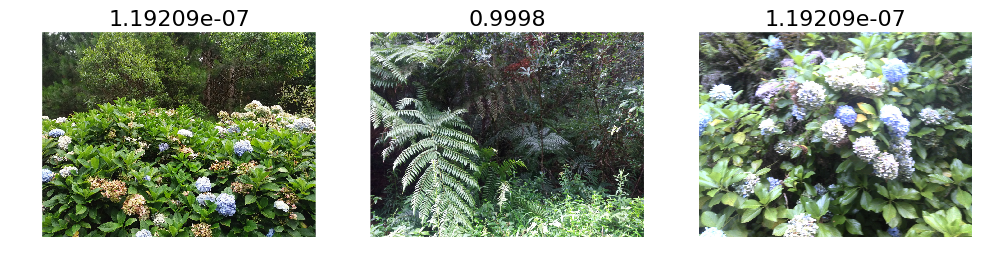

In [71]:
#1. A few correct labels at random
correct = np.where(our_labels==expected_labels)[0]
print("Found %d correct labels of total %d") %(len(correct), len(expected_labels))
idx = permutation(correct)[:n_view]
plots_idx(idx, our_predictions[idx])

Found 21 incorrect labels


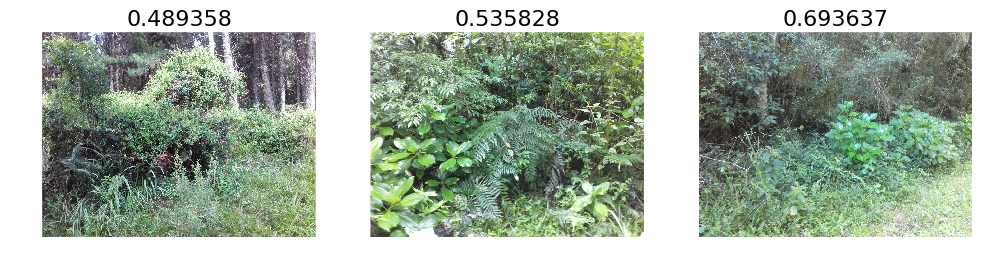

In [72]:
#2. A few incorrect labels at random
incorrect = np.where(our_labels!=expected_labels)[0]
print "Found %d incorrect labels" % len(incorrect)
idx = permutation(incorrect)[:n_view]
plots_idx(idx, our_predictions[idx])

As well as looking at the overall metrics, it's also a good idea to look at examples of each of:
1. A few correct labels at random
2. A few incorrect labels at random
3. The most correct labels of each class (ie those with highest probability that are correct)
4. The most incorrect labels of each class (ie those with highest probability that are incorrect)
5. The most uncertain labels (ie those with probability closest to 0.5).

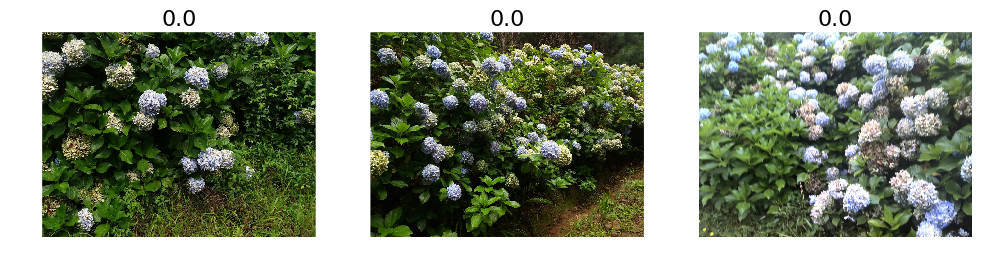

In [73]:
# 3a most correct of my invasive (= 0)
correct_predictions = our_predictions[correct]
sorted_correct_idx = np.argsort(correct_predictions)
# sorted_correct_idx is idx of min to max of selection of correct predictions != min to max of our_predictions
idx_s = correct[sorted_correct_idx][:n_view]
plots_idx(idx_s, our_predictions[idx_s])

# # Jeremy
# correct_cats_idx = np.where((our_labels==0) & (our_labels==expected_labels))[0]
# most_correct_cats_idx = np.argsort(our_predictions[correct_cats_idx])#[::-1] # idx of min to max cor inv pred
# # print(most_correct_cats_idx)
# idx_j = correct_cats_idx[most_correct_cats_idx][:n_view]
# plots_idx(idx_j, our_predictions[idx_j])
# # print(our_predictions[correct_cats_idx[most_correct_cats_idx]])

# # Comparison
# # print(np.in1d(sorted_correct_invasive_idx[:80], most_correct_cats_idx[:80]))
# print(our_predictions[idx_s], our_predictions[idx_j])

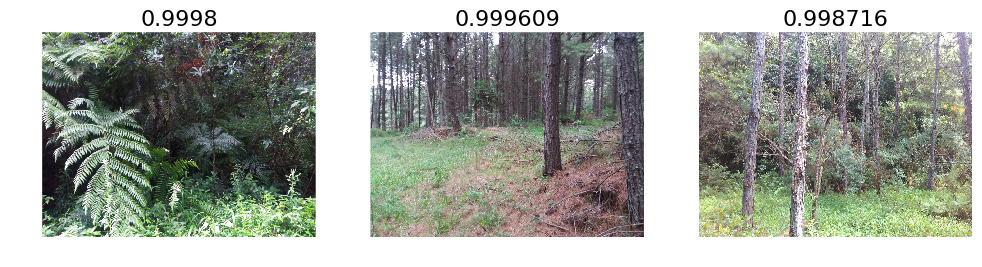

In [74]:
# 3a most correct of my non_invasive (= 1)
correct_predictions = our_predictions[correct]
sorted_correct_idx = np.argsort(correct_predictions)[::-1]
idx_s = correct[sorted_correct_idx][:n_view]
plots_idx(idx_s, our_predictions[idx_s])

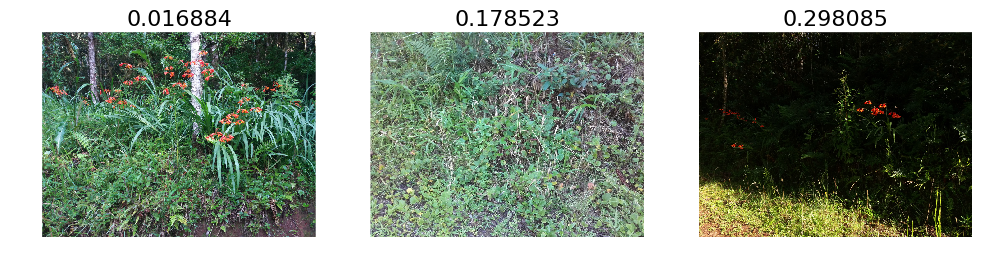

In [75]:
# 4a most incorrect of my invasive (= 0)
incorrect_predictions = our_predictions[incorrect]
sorted_incorrect_idx = np.argsort(incorrect_predictions)#[::-1]
idx_s = incorrect[sorted_incorrect_idx][:n_view]
plots_idx(idx_s, our_predictions[idx_s])

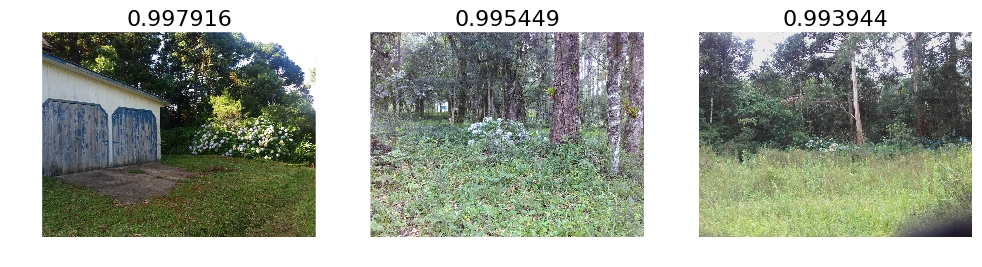

In [76]:
# 4b most incorrect of my non_invasive (= 1)
incorrect_predictions = our_predictions[incorrect]
sorted_incorrect_idx = np.argsort(incorrect_predictions)[::-1]
idx_s = incorrect[sorted_incorrect_idx][:n_view]
plots_idx(idx_s, our_predictions[idx_s])

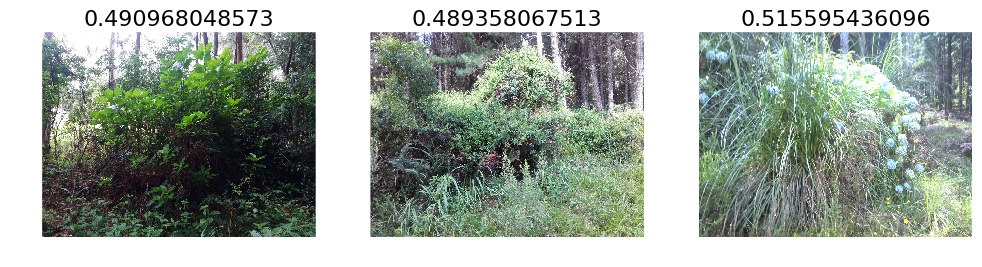

In [77]:
# 5 most uncertain, closest to 0.5
def k_closest(sample, pivot, k):
    return sorted(enumerate(sample), key=lambda (n, v): abs(v - pivot))[:k]
uncertain = np.asarray(k_closest(our_predictions, 0.5, n_view))
uncertain_index = uncertain[:,0].astype(int)
plots_idx(uncertain_index, uncertain[:,1])
# Jeremy
# most_uncertain = np.argsort(np.abs(our_predictions-0.5))
# plots_idx(most_uncertain[:n_view], our_predictions[most_uncertain])

## 3. Test and submit

In [62]:
%%time
# vgg.model.load_weights(model_path+run_approach_name+'last.h5')
test_batches, test_probs = vgg.test(test_path, batch_size = batch_size*2)

Found 1531 images belonging to 1 classes.
CPU times: user 1min 28s, sys: 8.86 s, total: 1min 37s
Wall time: 58.4 s


In [63]:
filenames = test_batches.filenames

In [64]:
#Save our test results arrays so we can use them again later
save_array(results_path + 'test_preds.dat', test_probs)
save_array(results_path + 'filenames.dat', filenames)

In [65]:
file_numbers = [int(filenames[i][8:-4]) for i in range(len(filenames))]

[ 0.9993  0.2753  0.0964]


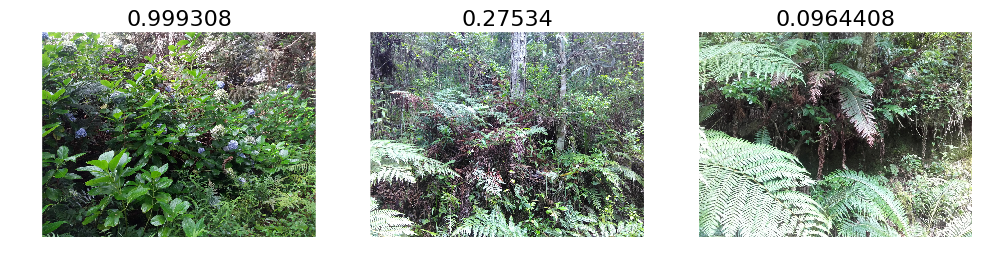

In [30]:
print(test_probs[:3,0])
def plots_idxs(idx, titles=None):
    plots([image.load_img(path+'/test/'+filenames[i]) for i in idx], titles=titles)
plots_idxs([0,1,2], test_probs[:3,0])

In [66]:
def write_csv(name, predictions, details=''):
    with open(path+'/results/'+'test_'+ str(details) +'.csv', 'wb') as f:
        fieldnames = ['name', 'invasive']
        wr = csv.writer(f, delimiter=',')
        wr.writerow(fieldnames)
        for i in range(len(predictions)):
            wr.writerow([name[i],predictions[i]])
    return FileLink(DATA_PATH+'/results/'+'test_'+ str(details) +'.csv')

In [67]:
write_csv(file_numbers, test_probs[:,0], run_approach_name)

/home/ubuntu/fastai/data/invasivespecies/results/test_loss_binary.csv

In [55]:
%cd ~/fastai

/home/ubuntu/fastai


In [32]:
%ls

1_image_recognition_catsanddogs.ipynb      lesson1.ipynb    vgg16.pyc
1_image_recognition_invasivespecies.ipynb  resnet50.py*     vgg16bn.py*
2_CNNs.ipynb                               test.csv         vgg16bn.pyc
Lesson_3.ipynb                             utils.py*        vgg16stijn.py*
batches.npy                                utils.pyc        vgg16stijn.pyc
data/                                      utils_anders.py
edit_util_files.ipynb                      vgg16.py*


In [57]:
from IPython.display import FileLink
FileLink('data/invasiveplants/results/test_fourth_43_epochs.csv')

/home/ubuntu/fastai/data/invasiveplants/results/test_fourth_43_epochs.csv

# Utils

### vgg16stijn.py

In [5]:
# %%writefile vgg16stijn.py
import json
import numpy as np
from keras.utils.data_utils import get_file
from keras.preprocessing import image
from keras.models import Sequential
from keras.layers.convolutional import Convolution2D, ZeroPadding2D
from keras.layers.pooling import MaxPooling2D
from keras.layers.core import Dense, Dropout, Flatten, Lambda
from keras.optimizers import Adam #, SGD, RMSprop

vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def RGB_to_BGR(x):
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr
        
class Vgg16Stijn():
    def __init__(self): # sets up neural network
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()
    
    def create(self): # build actual network
        """
            Builds neural network and loads pretrained vgg16 model weights
        """
        model = self.model = Sequential()
        model.add(Lambda(RGB_to_BGR, input_shape=(3,224,224), output_shape=(3,224,224))) #change rgb to bgr
        
        self.add_convlayers(2, 64)
        self.add_convlayers(2, 128)
        self.add_convlayers(3, 256)
        self.add_convlayers(3, 512)
        self.add_convlayers(3, 512)
        
        model.add(Flatten())
        self.add_fullconnect()
        self.add_fullconnect()
        model.add(Dense(1000, activation='softmax'))

        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))
    
    def add_convlayers(self, layers, filters):
        """
            Adds a specified number of ZeroPadding (line of zeros around image) and Covolution layers
            to the model, and a MaxPooling (outputs max value of group) layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer. I think these are the 
                                number of learnable features per layer
        """
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))
    
    def add_fullconnect(self):
        """
            Adds a fully connected layer of 4096 neurons (with 64x64 dimension) to the model with a
            Dropout of 0.5. Dropout is random 0.5 of the input nodes are set to 0 to prevent overfitting.

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096, activation='relu')) # fully connected layer with 64x64 dimension
        model.add(Dropout(0.5)) # random half of the input nodes are set to 0 to prevent overfitting
    
    def get_classes(self):
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]
        
    def batch_iterator(self, path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        return gen.flow_from_directory(directory=path, target_size=(224,224),
                    class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)

    def change_number_outputnodes(self, num):
        model = self.model
        model.pop()
        for layer in model.layers:
            layer.trainable = False
        model.add(Dense(num,activation='softmax'))
        self.compile()
        
    def compile(self, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),
                loss='binary_crossentropy', metrics=['accuracy'])
    
    def finetune_to_classes(self, batches):
        """
            Adjusts final layer to correct number of output nodes and updates class labels.
            
            Args:
                batches: keras.preprocessing.image.ImageDataGenerator opbject with flow_from_directory()
        """
        self.change_number_outputnodes(batches.nb_class)
        classes = list(iter(batches.class_indices)) 
        # creates list of classes from dict item 'batches.class_indices'
        # batches.class_indices i.e. {'invasive': 1, 'non_invasive': 0}
        for key in batches.class_indices:
            classes[batches.class_indices[key]] = key
        # orders class keys by value in dict like ['non_invasive', 'invasive'] because key 'non_invasive' has value 0
        self.classes = classes
        
    def fit(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        csv_logger = CSVLogger('training.log')
        self.model.fit_generator(batches, callbacks=[csv_logger], samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)
        print('fit done')
    
    def fit_n_save(self, batches, val_batches, nb_epoch, results_path, extra_info=None):
        """
            Uses fit and saves weights every epoch
            
            Args:
                batches, val_batches, nb_epoch
                extra_info: string attached to filename
        """
        latest_weights_filename = None
        for epoch in range(nb_epoch):
            print('Epoch %d' %epoch)
            self.fit(batches, val_batches, nb_epoch=1)
            latest_weights_filename = 'ft%d%s.h5' %(epoch+1, extra_info)
            self.model.save_weights(results_path+latest_weights_filename)
        print "Completed %s fit operations and saved in " + latest_weights_filename % nb_epoch
    
    def test(self, path, batch_size=8):
        """
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.batch_iterator(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)

Overwriting vgg16stijn.py


### vgg16.py

In [ ]:
# %load vgg16.py
from __future__ import division, print_function

import os, json
from glob import glob
import numpy as np
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom

from keras import backend as K
from keras.layers.normalization import BatchNormalization
from keras.utils.data_utils import get_file
from keras.models import Sequential
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.layers.convolutional import Convolution2D, MaxPooling2D, ZeroPadding2D
from keras.layers.pooling import GlobalAveragePooling2D
from keras.optimizers import SGD, RMSprop, Adam
from keras.preprocessing import image

# In case we are going to use the TensorFlow backend we need to explicitly set the Theano image ordering
from keras import backend as K
K.set_image_dim_ordering('th')


vgg_mean = np.array([123.68, 116.779, 103.939], dtype=np.float32).reshape((3,1,1))
def vgg_preprocess(x):
    """
        Subtracts the mean RGB value, and transposes RGB to BGR.
        The mean RGB was computed on the image set used to train the VGG model.

        Args: 
            x: Image array (height x width x channels)
        Returns:
            Image array (height x width x transposed_channels)
    """
    x = x - vgg_mean
    return x[:, ::-1] # reverse axis rgb->bgr


class Vgg16():
    """
        The VGG 16 Imagenet model
    """


    def __init__(self):
        self.FILE_PATH = 'http://files.fast.ai/models/'
        self.create()
        self.get_classes()


    def get_classes(self):
        """
            Downloads the Imagenet classes index file and loads it to self.classes.
            The file is downloaded only if it not already in the cache.
        """
        fname = 'imagenet_class_index.json'
        fpath = get_file(fname, self.FILE_PATH+fname, cache_subdir='models')
        with open(fpath) as f:
            class_dict = json.load(f)
        self.classes = [class_dict[str(i)][1] for i in range(len(class_dict))]

    def predict(self, imgs, details=False):
        """
            Predict the labels of a set of images using the VGG16 model.

            Args:
                imgs (ndarray)    : An array of N images (size: N x width x height x channels).
                details : ??
            
            Returns:
                preds (np.array) : Highest confidence value of the predictions for each image.
                idxs (np.ndarray): Class index of the predictions with the max confidence.
                classes (list)   : Class labels of the predictions with the max confidence.
        """
        # predict probability of each class for each image
        all_preds = self.model.predict(imgs)
        # for each image get the index of the class with max probability
        idxs = np.argmax(all_preds, axis=1)
        # get the values of the highest probability for each image
        preds = [all_preds[i, idxs[i]] for i in range(len(idxs))]
        # get the label of the class with the highest probability for each image
        classes = [self.classes[idx] for idx in idxs]
        return np.array(preds), idxs, classes


    def ConvBlock(self, layers, filters):
        """
            Adds a specified number of ZeroPadding and Covolution layers
            to the model, and a MaxPooling layer at the very end.

            Args:
                layers (int):   The number of zero padded convolution layers
                                to be added to the model.
                filters (int):  The number of convolution filters to be 
                                created for each layer.
        """
        model = self.model
        for i in range(layers):
            model.add(ZeroPadding2D((1, 1)))
            model.add(Convolution2D(filters, 3, 3, activation='relu'))
        model.add(MaxPooling2D((2, 2), strides=(2, 2)))


    def FCBlock(self):
        """
            Adds a fully connected layer of 4096 neurons to the model with a
            Dropout of 0.5

            Args:   None
            Returns:   None
        """
        model = self.model
        model.add(Dense(4096, activation='relu'))
        model.add(Dropout(0.5))


    def create(self):
        """
            Creates the VGG16 network achitecture and loads the pretrained weights.

            Args:   None
            Returns:   None
        """
        model = self.model = Sequential()
        model.add(Lambda(vgg_preprocess, input_shape=(3,224,224), output_shape=(3,224,224)))

        self.ConvBlock(2, 64)
        self.ConvBlock(2, 128)
        self.ConvBlock(3, 256)
        self.ConvBlock(3, 512)
        self.ConvBlock(3, 512)

        model.add(Flatten())
        self.FCBlock()
        self.FCBlock()
        model.add(Dense(1000, activation='softmax'))

        fname = 'vgg16.h5'
        model.load_weights(get_file(fname, self.FILE_PATH+fname, cache_subdir='models'))


    def get_batches(self, path, gen=image.ImageDataGenerator(), shuffle=True, batch_size=8, class_mode='categorical'):
        """
            Takes the path to a directory, and generates batches of augmented/normalized data. Yields batches indefinitely, in an infinite loop.

            See Keras documentation: https://keras.io/preprocessing/image/
        """
        return gen.flow_from_directory(path, target_size=(224,224),
                class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


    def ft(self, num):
        """
            Replace the last layer of the model with a Dense (fully connected) layer of num neurons.
            Will also lock the weights of all layers except the new layer so that we only learn
            weights for the last layer in subsequent training.

            Args:
                num (int) : Number of neurons in the Dense layer
            Returns:
                None
        """
        model = self.model
        model.pop()
        for layer in model.layers: layer.trainable=False
        model.add(Dense(num, activation='softmax'))
        self.compile()

    def finetune(self, batches):
        """
            Modifies the original VGG16 network architecture and updates self.classes for new training data.
            
            Args:
                batches : A keras.preprocessing.image.ImageDataGenerator object.
                          See definition for get_batches().
        """
        self.ft(batches.nb_class)
        classes = list(iter(batches.class_indices)) # get a list of all the class labels
        # batches.class_indices is a dict with the class name as key and an index as value
        # eg. {'cats': 0, 'dogs': 1}

        # sort the class labels by index according to batches.class_indices and update model.classes
        for c in batches.class_indices:
            classes[batches.class_indices[c]] = c
        self.classes = classes


    def compile(self, lr=0.001):
        """
            Configures the model for training.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.compile(optimizer=Adam(lr=lr),
                loss='categorical_crossentropy', metrics=['accuracy'])


    def fit_data(self, trn, labels,  val, val_labels,  nb_epoch=1, batch_size=64):
        """
            Trains the model for a fixed number of epochs (iterations on a dataset).
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit(trn, labels, nb_epoch=nb_epoch,
                validation_data=(val, val_labels), batch_size=batch_size)


    def fit(self, batches, val_batches, nb_epoch=1):
        """
            Fits the model on data yielded batch-by-batch by a Python generator.
            See Keras documentation: https://keras.io/models/model/
        """
        self.model.fit_generator(batches, samples_per_epoch=batches.nb_sample, nb_epoch=nb_epoch,
                validation_data=val_batches, nb_val_samples=val_batches.nb_sample)


    def test(self, path, batch_size=8):
        """
            Predicts the classes using the trained model on data yielded batch-by-batch.

            Args:
                path (string):  Path to the target directory. It should contain one subdirectory 
                                per class.
                batch_size (int): The number of images to be considered in each batch.
            
            Returns:
                test_batches, numpy array(s) of predictions for the test_batches.
    
        """
        test_batches = self.get_batches(path, shuffle=False, batch_size=batch_size, class_mode=None)
        return test_batches, self.model.predict_generator(test_batches, test_batches.nb_sample)



### ma code

In [ ]:
path = DATA_HOME_DIR
# path = DATA_HOME_DIR + '/sample/'

In [14]:
from __future__ import division,print_function

import os, json
from glob import glob
import numpy as np
np.set_printoptions(precision=4, linewidth=100)
from matplotlib import pyplot as plt
import csv
import math

import utils; reload(utils)
from utils import plots
import vgg16; reload(vgg16)
from vgg16 import Vgg16

batch_size = 8

vgg = Vgg16()
# Grab a few images at a time for training and validation.
# NB: They must be in subdirectories named based on their category
batches = vgg.get_batches(path+'train', batch_size=batch_size)
val_batches = vgg.get_batches(path+'valid', batch_size=batch_size*2)
test_batches = vgg.get_batches(path+'temptest', batch_size=batch_size, shuffle=False)
vgg.finetune(batches)
vgg.fit(batches, val_batches, nb_epoch=2)

Found 2111 images belonging to 2 classes.
Found 184 images belonging to 2 classes.
Found 1531 images belonging to 1 classes.
Epoch 1/2
  72/2111 [>.............................] - ETA: 828s - loss: 1.0159 - acc: 0.6528

KeyboardInterrupt: 

In [3]:
def batch_dogness(test_batches):
    imgs,nolabel = next(test_batches)
    preds, idxs, labels = vgg.predict(imgs)
    dogness = np.multiply(preds, idxs) + np.multiply(1.-preds, 1-idxs)
    return dogness

In [10]:
def predict_order_testset(testfolder):
#     files_names = os.listdir(path+testfolder)
    files_names = test_batches.filenames
    files_names = [int(files_names[i][5:-4]) for i in range(len(files_names))]
    N = int(math.ceil(len(files_names)/batch_size))
#     predictions = [x for i in range(N) for x in batch_dogness(test_batches).tolist()]
    predictions = [x for i in range(N) for x in batch_dogness(test_batches).clip(0.01,0.99).tolist()] #Use clipping because of log loss judgement by Kaggle
    predictions_ordered = [x for (y,x) in sorted(zip(files_names,predictions))]
    return predictions_ordered

In [11]:
def write_csv(predictions_ordered):
    with open(path+'test.csv', 'wb') as f:
        fieldnames = ['id', 'label']
        wr = csv.writer(f, delimiter=',')
        wr.writerow(fieldnames)
        for i in range(len(predictions_ordered)):
            wr.writerow([i+1,predictions_ordered[i]])

In [12]:
predictions = predict_order_testset('temptest/test')
write_csv(predictions)

### utils.py

In [63]:
%%writefile utils_anders.py
# %load utils.py

from __future__ import division,print_function
import math, os, json, sys, re
import cPickle as pickle
from glob import glob
import numpy as np
from matplotlib import pyplot as plt
from operator import itemgetter, attrgetter, methodcaller
from collections import OrderedDict
import itertools
from itertools import chain

import pandas as pd
import PIL
from PIL import Image
from numpy.random import random, permutation, randn, normal, uniform, choice
from numpy import newaxis
import scipy
from scipy import misc, ndimage
from scipy.ndimage.interpolation import zoom
from scipy.ndimage import imread
from sklearn.metrics import confusion_matrix
import bcolz
from sklearn.preprocessing import OneHotEncoder
from sklearn.manifold import TSNE

from IPython.lib.display import FileLink

import theano
from theano import shared, tensor as T
from theano.tensor.nnet import conv2d, nnet
from theano.tensor.signal import pool

import keras
from keras import backend as K
from keras.utils.data_utils import get_file
from keras.utils import np_utils
from keras.utils.np_utils import to_categorical
from keras.models import Sequential, Model
from keras.layers import Input, Embedding, Reshape, merge, LSTM, Bidirectional
from keras.layers import TimeDistributed, Activation, SimpleRNN, GRU
from keras.layers.core import Flatten, Dense, Dropout, Lambda
from keras.regularizers import l2, activity_l2, l1, activity_l1
from keras.layers.normalization import BatchNormalization
from keras.optimizers import SGD, RMSprop, Adam
from keras.utils.layer_utils import layer_from_config
from keras.metrics import categorical_crossentropy, categorical_accuracy
from keras.layers.convolutional import *
from keras.preprocessing import image, sequence
from keras.preprocessing.text import Tokenizer

from vgg16 import *
from vgg16bn import *
np.set_printoptions(precision=4, linewidth=100)


to_bw = np.array([0.299, 0.587, 0.114])

def gray(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).dot(to_bw)
    else:
        return np.rollaxis(img, 0, 3).dot(to_bw)

def to_plot(img):
    if K.image_dim_ordering() == 'tf':
        return np.rollaxis(img, 0, 1).astype(np.uint8)
    else:
        return np.rollaxis(img, 0, 3).astype(np.uint8)

def plot(img):
    plt.imshow(to_plot(img))


def floor(x):
    return int(math.floor(x))
def ceil(x):
    return int(math.ceil(x))

def plots(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    if type(ims[0]) is np.ndarray:
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')

def plots2(ims, figsize=(12,6), rows=1, interp=False, titles=None):
    print('1', 'type(ims) = ',type(ims), ims.shape)
    if type(ims[0]) is np.ndarray:
        print('2')
        ims = np.array(ims).astype(np.uint8)
        if (ims.shape[-1] != 3):
            ims = ims.transpose((0,2,3,1))
    f = plt.figure(figsize=figsize)
    print('3')
    for i in range(len(ims)):
        sp = f.add_subplot(rows, len(ims)//rows, i+1)
        sp.axis('Off')
        if titles is not None:
            sp.set_title(titles[i], fontsize=16)
        plt.imshow(ims[i], interpolation=None if interp else 'none')
        print('4',i)
    print('5')

def do_clip(arr, mx):
    clipped = np.clip(arr, (1-mx)/1, mx)
    return clipped/clipped.sum(axis=1)[:, np.newaxis]


def get_batches(dirname, gen=image.ImageDataGenerator(), shuffle=True, batch_size=4, class_mode='categorical',
                target_size=(224,224)):
    return gen.flow_from_directory(dirname, target_size=target_size,
            class_mode=class_mode, shuffle=shuffle, batch_size=batch_size)


def onehot(x):
    return to_categorical(x)


def wrap_config(layer):
    return {'class_name': layer.__class__.__name__, 'config': layer.get_config()}


def copy_layer(layer): return layer_from_config(wrap_config(layer))


def copy_layers(layers): return [copy_layer(layer) for layer in layers]


def copy_weights(from_layers, to_layers):
    for from_layer,to_layer in zip(from_layers, to_layers):
        to_layer.set_weights(from_layer.get_weights())


def copy_model(m):
    res = Sequential(copy_layers(m.layers))
    copy_weights(m.layers, res.layers)
    return res


def insert_layer(model, new_layer, index):
    res = Sequential()
    for i,layer in enumerate(model.layers):
        if i==index: res.add(new_layer)
        copied = layer_from_config(wrap_config(layer))
        res.add(copied)
        copied.set_weights(layer.get_weights())
    return res


def adjust_dropout(weights, prev_p, new_p):
    scal = (1-prev_p)/(1-new_p)
    return [o*scal for o in weights]


def get_data(path, target_size=(224,224)):
    batches = get_batches(path, shuffle=False, batch_size=1, class_mode=None, target_size=target_size)
    return np.concatenate([batches.next() for i in range(batches.nb_sample)])


def plot_confusion_matrix(cm, classes, normalize=False, title='Confusion matrix', cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    (This function is copied from the scikit docs.)
    """
    plt.figure()
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
    print(cm)
    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j], horizontalalignment="center", color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')


def save_array(fname, arr):
    c=bcolz.carray(arr, rootdir=fname, mode='w')
    c.flush()


def load_array(fname):
    return bcolz.open(fname)[:]


def mk_size(img, r2c):
    r,c,_ = img.shape
    curr_r2c = r/c
    new_r, new_c = r,c
    if r2c>curr_r2c:
        new_r = floor(c*r2c)
    else:
        new_c = floor(r/r2c)
    arr = np.zeros((new_r, new_c, 3), dtype=np.float32)
    r2=(new_r-r)//2
    c2=(new_c-c)//2
    arr[floor(r2):floor(r2)+r,floor(c2):floor(c2)+c] = img
    return arr


def mk_square(img):
    x,y,_ = img.shape
    maxs = max(img.shape[:2])
    y2=(maxs-y)//2
    x2=(maxs-x)//2
    arr = np.zeros((maxs,maxs,3), dtype=np.float32)
    arr[floor(x2):floor(x2)+x,floor(y2):floor(y2)+y] = img
    return arr


def vgg_ft(out_dim):
    vgg = Vgg16()
    vgg.ft(out_dim)
    model = vgg.model
    return model

def vgg_ft_bn(out_dim):
    vgg = Vgg16BN()
    vgg.ft(out_dim)
    model = vgg.model
    return model


def get_classes(path):
    batches = get_batches(path+'train', shuffle=False, batch_size=1)
    val_batches = get_batches(path+'valid', shuffle=False, batch_size=1)
    test_batches = get_batches(path+'test', shuffle=False, batch_size=1)
    return (val_batches.classes, batches.classes, onehot(val_batches.classes), onehot(batches.classes),
        val_batches.filenames, batches.filenames, test_batches.filenames)


def split_at(model, layer_type):
    layers = model.layers
    layer_idx = [index for index,layer in enumerate(layers)
                 if type(layer) is layer_type][-1]
    return layers[:layer_idx+1], layers[layer_idx+1:]


class MixIterator(object):
    def __init__(self, iters):
        self.iters = iters
        self.multi = type(iters) is list
        if self.multi:
            self.N = sum([it[0].N for it in self.iters])
        else:
            self.N = sum([it.N for it in self.iters])

    def reset(self):
        for it in self.iters: it.reset()

    def __iter__(self):
        return self

    def next(self, *args, **kwargs):
        if self.multi:
            nexts = [[next(it) for it in o] for o in self.iters]
            n0 = np.concatenate([n[0] for n in nexts])
            n1 = np.concatenate([n[1] for n in nexts])
            return (n0, n1)
        else:
            nexts = [next(it) for it in self.iters]
            n0 = np.concatenate([n[0] for n in nexts])
            n1 = np.concatenate([n[1] for n in nexts])
            return (n0, n1)



Overwriting utils_anders.py
